In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
original_df = pd.read_csv('/content/drive/MyDrive/data/data-challenge-original.csv')
protected_df = pd.read_csv('/content/drive/MyDrive/data/protected_data_challenge.csv')

In [ ]:
print("Original:", original_df.shape)
print("Protected:", protected_df.shape)
print(original_df.head())

Original: (20000, 18)
Protected: (20000, 18)
   Identifier              Name  Age     Occupation City_Tier  Dependents  \
0           0       Gopal Palla   49  Self_Employed    Tier_1           0   
1           1      Pranav Nanda   34        Retired    Tier_2           2   
2           2  Neelima Sengupta   35        Student    Tier_3           1   
3           3     Balendra Babu   21  Self_Employed    Tier_3           0   
4           4      Anamika Char   52   Professional    Tier_2           4   

      Income      Rent  Loan_Repayment  Insurance  Groceries  Transport  \
0   44637.25  13391.17            0.00    2206.49    6658.77    2636.97   
1   26858.60   5371.72            0.00     869.52    2818.44    1543.02   
2   50367.61   7555.14         4612.10    2201.80    6313.22    3221.40   
3  101455.60  15218.34         6809.44    4889.42   14690.15    7106.13   
4   24875.28   4975.06         3112.61     635.91    3034.33    1276.16   

   Eating_Out  Entertainment  Utilities  

# **PROCESS 1(COSINE SIMILARITY)**

In [ ]:
drop_cols = ['Name', 'Identifier', 'Occupation', 'City_Tier']
original_features = original_df.drop(columns=drop_cols, errors='ignore')
protected_features = protected_df.drop(columns=drop_cols, errors='ignore')

In [ ]:
scaler = StandardScaler()
original_scaled = scaler.fit_transform(original_features)
protected_scaled = scaler.transform(protected_features)

In [ ]:
# Step 5: Compute Cosine Similarity
similarity_matrix = cosine_similarity(protected_scaled, original_scaled)

In [ ]:
# Step 6: Get Best Matches
predicted_indices = similarity_matrix.argmax(axis=1)

In [ ]:
# Step 7: Save Matching Results
protected_df.to_csv("match_results_cosine.csv", index=False)
print("Match results saved to match_results_cosine.csv")

Match results saved to match_results_cosine.csv


# **PROCESS 2(BATCH MATCH)**

*Memory Efficient Matching*

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist


original_df = pd.read_csv("/content/drive/MyDrive/data/data-challenge-original.csv")
protected_df = pd.read_csv("/content/drive/MyDrive/data/protected_data_challenge.csv")

exclude_cols = ['Name', 'Identifier']
common_cols = list(set(original_df.columns).intersection(set(protected_df.columns)))
numeric_cols = [col for col in common_cols if col not in exclude_cols and np.issubdtype(original_df[col].dtype, np.number)]

# Step 3: Feature Weighting
feature_weights = {
    'Income': 2.0, 'Groceries': 1.8, 'Rent': 1.5,
    'Loan_Repayment': 1.5, 'Insurance': 1.3,
    'Age': 1.0, 'Occupation': 1.0, 'City_Tier': 1.0,
    'Dependents': 1.0
}
weights = np.array([feature_weights.get(col, 1.0) for col in numeric_cols])

# Step 4: Standardization + Weighting
scaler = StandardScaler()
original_scaled = scaler.fit_transform(original_df[numeric_cols])
protected_scaled = scaler.transform(protected_df[numeric_cols])
original_weighted = original_scaled * weights
protected_weighted = protected_scaled * weights

# Step 5: Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)
original_pca = pca.fit_transform(original_weighted)
protected_pca = pca.transform(protected_weighted)

# Step 6: Efficient Matching in Batches
def batched_matching(protected_data, original_data, batch_size=1000):
    matched_indices = []
    for i in range(0, protected_data.shape[0], batch_size):
        batch = protected_data[i:i+batch_size]
        dists = cdist(batch, original_data, metric='euclidean')
        batch_indices = np.argmin(dists, axis=1)
        matched_indices.extend(batch_indices)
    return matched_indices

matched_indices = batched_matching(protected_pca, original_pca)

# Step 7: Reconstruct Matched DataFrame
protected_df['Matched_Index'] = matched_indices
matched_original_rows = original_df.iloc[matched_indices].reset_index(drop=True)
match_results = pd.concat([protected_df.reset_index(drop=True), matched_original_rows.add_prefix("Original_")], axis=1)

# Step 8: Save Final Results
match_results.to_csv("match_results.csv", index=False)
print("Matching complete. Results saved in match_results.csv.")



Matching complete. Results saved in match_results.csv.


# *DECODING THE NAME AND IDENTIFIER*

# **PROCESS 3 DECODING (similarity matrix using Euclidean distance)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


original_df = pd.read_csv("/content/drive/MyDrive/data/data-challenge-original.csv")
protected_df = pd.read_csv("/content/drive/MyDrive/data/protected_data_challenge.csv")

features = ['Age', 'Dependents', 'Income',
            'Rent', 'Loan_Repayment', 'Insurance', 'Groceries']

scaler = StandardScaler()
original_scaled = scaler.fit_transform(original_df[features])
protected_scaled = scaler.transform(protected_df[features])

# Create a similarity matrix using Euclidean distance
from scipy.spatial.distance import cdist
distances = cdist(protected_scaled, original_scaled, metric='euclidean')

matches = distances.argmin(axis=1)

decoded_df = protected_df.copy()
decoded_df['Decoded_Name'] = original_df.loc[matches, 'Name'].values
decoded_df['Decoded_Identifier'] = original_df.loc[matches, 'Identifier'].values

decoded_df.to_csv("decoded_data.csv", index=False)

# **Process 4 by matching each row to the most similar row**

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
import numpy as np

original_df = pd.read_csv("/content/drive/MyDrive/data/data-challenge-original.csv")
protected_df = pd.read_csv("/content/drive/MyDrive/data/protected_data_challenge.csv")

print(original_df.head())
print(protected_df.head())

matching_columns = [
    'Age', 'Occupation', 'City_Tier', 'Dependents',
    'Income', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries'
]

numeric_features = ['Age', 'Income', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries']
categorical_features = ['Occupation', 'City_Tier', 'Dependents']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fit on original, transform both datasets
original_features = preprocessor.fit_transform(original_df[matching_columns])
protected_features = preprocessor.transform(protected_df[matching_columns])

# Calculate pairwise distances
distances = cdist(protected_features, original_features, metric='euclidean')

# Find best match for each protected record
best_match_indices = distances.argmin(axis=1)
best_match_scores = distances.min(axis=1)  # distance (lower = better match)

# Add decoded information
decoded_df = protected_df.copy()
decoded_df['Decoded_Name'] = original_df.loc[best_match_indices, 'Name'].values
decoded_df['Decoded_Identifier'] = original_df.loc[best_match_indices, 'Identifier'].values
decoded_df['Matching_Score'] = best_match_scores

   Identifier              Name  Age     Occupation City_Tier  Dependents  \
0           0       Gopal Palla   49  Self_Employed    Tier_1           0   
1           1      Pranav Nanda   34        Retired    Tier_2           2   
2           2  Neelima Sengupta   35        Student    Tier_3           1   
3           3     Balendra Babu   21  Self_Employed    Tier_3           0   
4           4      Anamika Char   52   Professional    Tier_2           4   

      Income      Rent  Loan_Repayment  Insurance  Groceries  Transport  \
0   44637.25  13391.17            0.00    2206.49    6658.77    2636.97   
1   26858.60   5371.72            0.00     869.52    2818.44    1543.02   
2   50367.61   7555.14         4612.10    2201.80    6313.22    3221.40   
3  101455.60  15218.34         6809.44    4889.42   14690.15    7106.13   
4   24875.28   4975.06         3112.61     635.91    3034.33    1276.16   

   Eating_Out  Entertainment  Utilities  Healthcare  Education  Miscellaneous  
0     

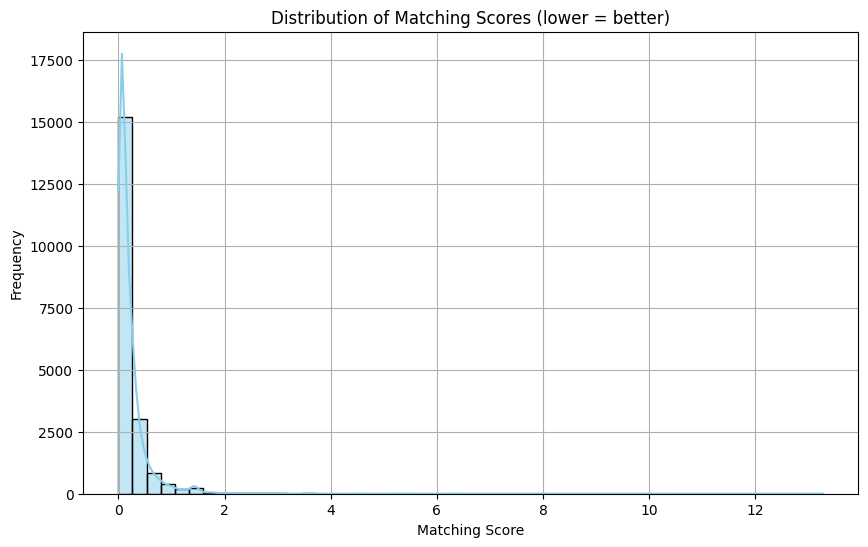

In [ ]:
#VISUALIZATION

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(decoded_df['Matching_Score'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Matching Scores (lower = better)')
plt.xlabel('Matching Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
decoded_df.to_csv("decoded_data_p4(matching_score).csv", index=False)
print("Decoded data saved successfully!")

Decoded data saved successfully!


# **Process 5 Fuzzyy Matching (with Feature Weights)**

In [ ]:
feature_weights = {
    'Age': 1.0,
    'Income': 2.0,
    'Rent': 1.2,
    'Loan_Repayment': 1.5,
    'Insurance': 0.5,
    'Groceries': 1.0,
    'Occupation': 1.5,
    'City_Tier': 1.0,
    'Dependents': 1.2
}

In [ ]:
#Custom Weighted Distance Function

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
import numpy as np

numeric_features = ['Age', 'Income', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries']
categorical_features = ['Occupation', 'City_Tier', 'Dependents']

# Combine for weighting
all_features_order = numeric_features + categorical_features

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Transform
original_transformed = preprocessor.fit_transform(original_df[all_features_order])
protected_transformed = preprocessor.transform(protected_df[all_features_order])

# Get feature names after encoding using Transformer
encoded_feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features).tolist() +
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
)

weights_array = np.array([
    feature_weights.get(feat.split('_')[0], 1.0)
    if '_' in feat else feature_weights.get(feat, 1.0)
    for feat in encoded_feature_names
])

# Apply weights
original_weighted = original_transformed * weights_array
protected_weighted = protected_transformed * weights_array

distances = cdist(protected_weighted, original_weighted, metric='euclidean')
best_match_indices = distances.argmin(axis=1)
best_match_scores = distances.min(axis=1)

decoded_df = protected_df.copy()
decoded_df['Decoded_Name'] = original_df.loc[best_match_indices, 'Name'].values
decoded_df['Decoded_Identifier'] = original_df.loc[best_match_indices, 'Identifier'].values
decoded_df['Weighted_Matching_Score'] = best_match_scores

decoded_df.to_csv("decoded_weighted_output_p5.csv", index=False)


# **Add Top-3 Candidate Matching**

In [ ]:
# Get indices of Top-3 matches for each protected row
top_3_indices = np.argsort(distances, axis=1)[:, :3]  # shape: (n_rows, 3)

# Get matching scores for top 3
top_3_scores = np.sort(distances, axis=1)[:, :3]

In [ ]:
top_matches = []

for i in range(len(protected_df)):
    row_matches = {
        'Protected_Index': i,
        'Top1_Name': original_df.loc[top_3_indices[i, 0], 'Name'],
        'Top1_Identifier': original_df.loc[top_3_indices[i, 0], 'Identifier'],
        'Top1_Score': top_3_scores[i, 0],

        'Top2_Name': original_df.loc[top_3_indices[i, 1], 'Name'],
        'Top2_Identifier': original_df.loc[top_3_indices[i, 1], 'Identifier'],
        'Top2_Score': top_3_scores[i, 1],

        'Top3_Name': original_df.loc[top_3_indices[i, 2], 'Name'],
        'Top3_Identifier': original_df.loc[top_3_indices[i, 2], 'Identifier'],
        'Top3_Score': top_3_scores[i, 2],
    }
    top_matches.append(row_matches)

top_matches_df = pd.DataFrame(top_matches)

In [ ]:
# Add encrypted fields from protected_df to top_matches_df
result_df = pd.concat([protected_df.reset_index(drop=True), top_matches_df.drop(columns='Protected_Index')], axis=1)

# Save full Top-3 output
result_df.to_csv("top3_decoded_matches.csv", index=False)
print("Top-3 candidate decoding saved as 'top3_decoded_matches.csv'")

Top-3 candidate decoding saved as 'top3_decoded_matches.csv'


In [3]:
import pandas as pd
process_4=pd.read_csv('/content/decoded_data_p4(matching_score).csv')
process_5=pd.read_csv('/content/decoded_weighted_output_p5.csv')

process_4['Weighted_Matching_Score'] = process_5['Weighted_Matching_Score']
process_4.to_csv('final_decoded_data.csv', index=False)